## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas
import statsmodels.api as sm
from reproduction import *
from data_processing import *
from constants import *

## Constants

In [2]:
DAY_COUNT = 'day_count'
BINS = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

## Data Processing

In [3]:
# Loads data
full_logistics_data_df = load_full_logistics_data()
full_order_data_df = load_full_order_data()
item_df = load_item_data()

In [4]:
df = compute_action_time(full_logistics_data_df, full_order_data_df)
df = bin_action_time(df, bin_size=0.05)

# Merge rows with shipment score 1 and 2
df.loc[df[LOGISTICS_REVIEW_SCORE] <= 1, LOGISTICS_REVIEW_SCORE] = 2
# Calculate day count by taking ceiling of shipment time
df[DAY_COUNT] = df[SHIPMENT_TIME].dt.days.apply(np.ceil)
# Remove shipments with day count less than 1 or greater than 8
df = df[df[DAY_COUNT] <= 8]
df = df[df[DAY_COUNT] >= 1]
# Get item id from item det info
df[ITEM_ID] = df[ITEM_DETAIL_INFO].apply(
    lambda item_det_info: int(item_det_info.split(":")[0]))

# Clean up item info
item_df = item_df[item_df[ITEM_ID].isin(df[ITEM_ID])]
item_df = item_df[[ITEM_ID, MERCHANT_ID, BRAND_ID, CATEGORY_ID]]
item_df = item_df.drop_duplicates()

In [5]:
# Add dummy variable for analysis
df = add_dummy_variables(df, item_df)

In [6]:
subsample_df = df[(df[DAY_COUNT] == 2) & (df[ACTION_TIME_INTERVAL] == 0.0)]
subsample_df = subsample_df[[LOGISTICS_REVIEW_SCORE, ACTION_COUNT, MERCHANT_ID, BRAND_ID, CATEGORY_ID, LOGISTIC_COMPANY_ID, 
                            WEEK_COUNT, DAY_COUNT, FACILITY_COUNT, ARRIVE_COUNT, DEPART_COUNT, RECEIVE_COUNT, SCAN_COUNT]]
subsample_df = pd.get_dummies(subsample_df, columns=[BRAND_ID, CATEGORY_ID, MERCHANT_ID, LOGISTIC_COMPANY_ID, WEEK_COUNT], dtype=pd.Float32Dtype)
subsample_df

/var/folders/nh/tr3k4trs7m12_0mcmx875zdm0000gn/T/ipykernel_53834/2571246471.py:4: UserWarning: Instantiating Float32Dtype without any arguments.Pass a Float32Dtype instance to silence this warning.
  subsample_df = pd.get_dummies(subsample_df, columns=[BRAND_ID, CATEGORY_ID, MERCHANT_ID, LOGISTIC_COMPANY_ID, WEEK_COUNT], dtype=pd.Float32Dtype)


,logistics_review_score,action_count,day_count,facility_count,arrive_count,depart_count,receive_count,scan_count,brand_id_0.0,category_id_0.0,...,week_count_20,week_count_21,week_count_22,week_count_23,week_count_24,week_count_25,week_count_26,week_count_27,week_count_28,week_count_29
95,5.0,1,2.0,1,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,5.0,1,2.0,1,1.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154,5.0,1,2.0,1,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282,5.0,1,2.0,1,4.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,5.0,1,2.0,1,3.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39605336,4.0,2,2.0,1,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39605337,4.0,2,2.0,1,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39605439,5.0,2,2.0,1,0.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39605442,5.0,2,2.0,1,0.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
def run_ols(df: pandas.DataFrame, splitting_column_name: str, column_values: range):
    coefficients = []
    upper_conf_ints = []
    lower_conf_ints = []

    for value in column_values:
        bin_coefficients = []
        bin_upper_conf_ints = []
        bin_lower_conf_ints = []
        for bin in BINS:
            subsample_df = df[(df[splitting_column_name] == value) & (df[ACTION_TIME_INTERVAL] == bin)]
            subsample_df = subsample_df[[LOGISTICS_REVIEW_SCORE, ACTION_COUNT, MERCHANT_ID, BRAND_ID, CATEGORY_ID, LOGISTIC_COMPANY_ID, 
                                         WEEK_COUNT, DAY_COUNT, FACILITY_COUNT, ARRIVE_COUNT, DEPART_COUNT, RECEIVE_COUNT, SCAN_COUNT]]
            subsample_df = pd.get_dummies(subsample_df, columns=[BRAND_ID, CATEGORY_ID, MERCHANT_ID, LOGISTIC_COMPANY_ID, WEEK_COUNT])
            y = subsample_df[LOGISTICS_REVIEW_SCORE]
            cols = subsample_df.columns.to_list()
            cols.remove(LOGISTICS_REVIEW_SCORE)
            x = subsample_df[cols]
            # x = subsample_df[
            #     [ACTION_COUNT, WEEK_COUNT, DAY_COUNT, FACILITY_COUNT, ARRIVE_COUNT, DEPART_COUNT, RECEIVE_COUNT,
            #      SCAN_COUNT]]
            # x = subsample_df[
            #     [ACTION_COUNT, MERCHANT_ID, BRAND_ID, CATEGORY_ID, LOGISTIC_COMPANY_ID, WEEK_COUNT, DAY_COUNT,
            #      FACILITY_COUNT, ARRIVE_COUNT, DEPART_COUNT, RECEIVE_COUNT, SCAN_COUNT]]
            x = sm.add_constant(x)

            model = sm.OLS(y, x.astype(float))
            results = model.fit()
            conf_int = results.conf_int(alpha=0.1).loc[ACTION_COUNT]  # alpha=0.1 indicates 90% confidence interval
            bin_upper_conf_ints.append(conf_int[1])
            bin_lower_conf_ints.append(conf_int[0])
            bin_coefficients.append(results.params[ACTION_COUNT])
        coefficients.append(bin_coefficients)
        upper_conf_ints.append(bin_upper_conf_ints)
        lower_conf_ints.append(bin_lower_conf_ints)

    return coefficients, lower_conf_ints, upper_conf_ints

In [8]:
action_count_coefficients, action_count_lower_conf_ints, action_count_upper_conf_ints = run_ols(
    df, SHIPMENT_ACTION_COUNT, range(4, 11))
day_coefficients, day_lower_conf_ints, day_upper_conf_ints = run_ols(df, DAY_COUNT, range(2, 9))

## Plot

<Figure size 1200x800 with 0 Axes>

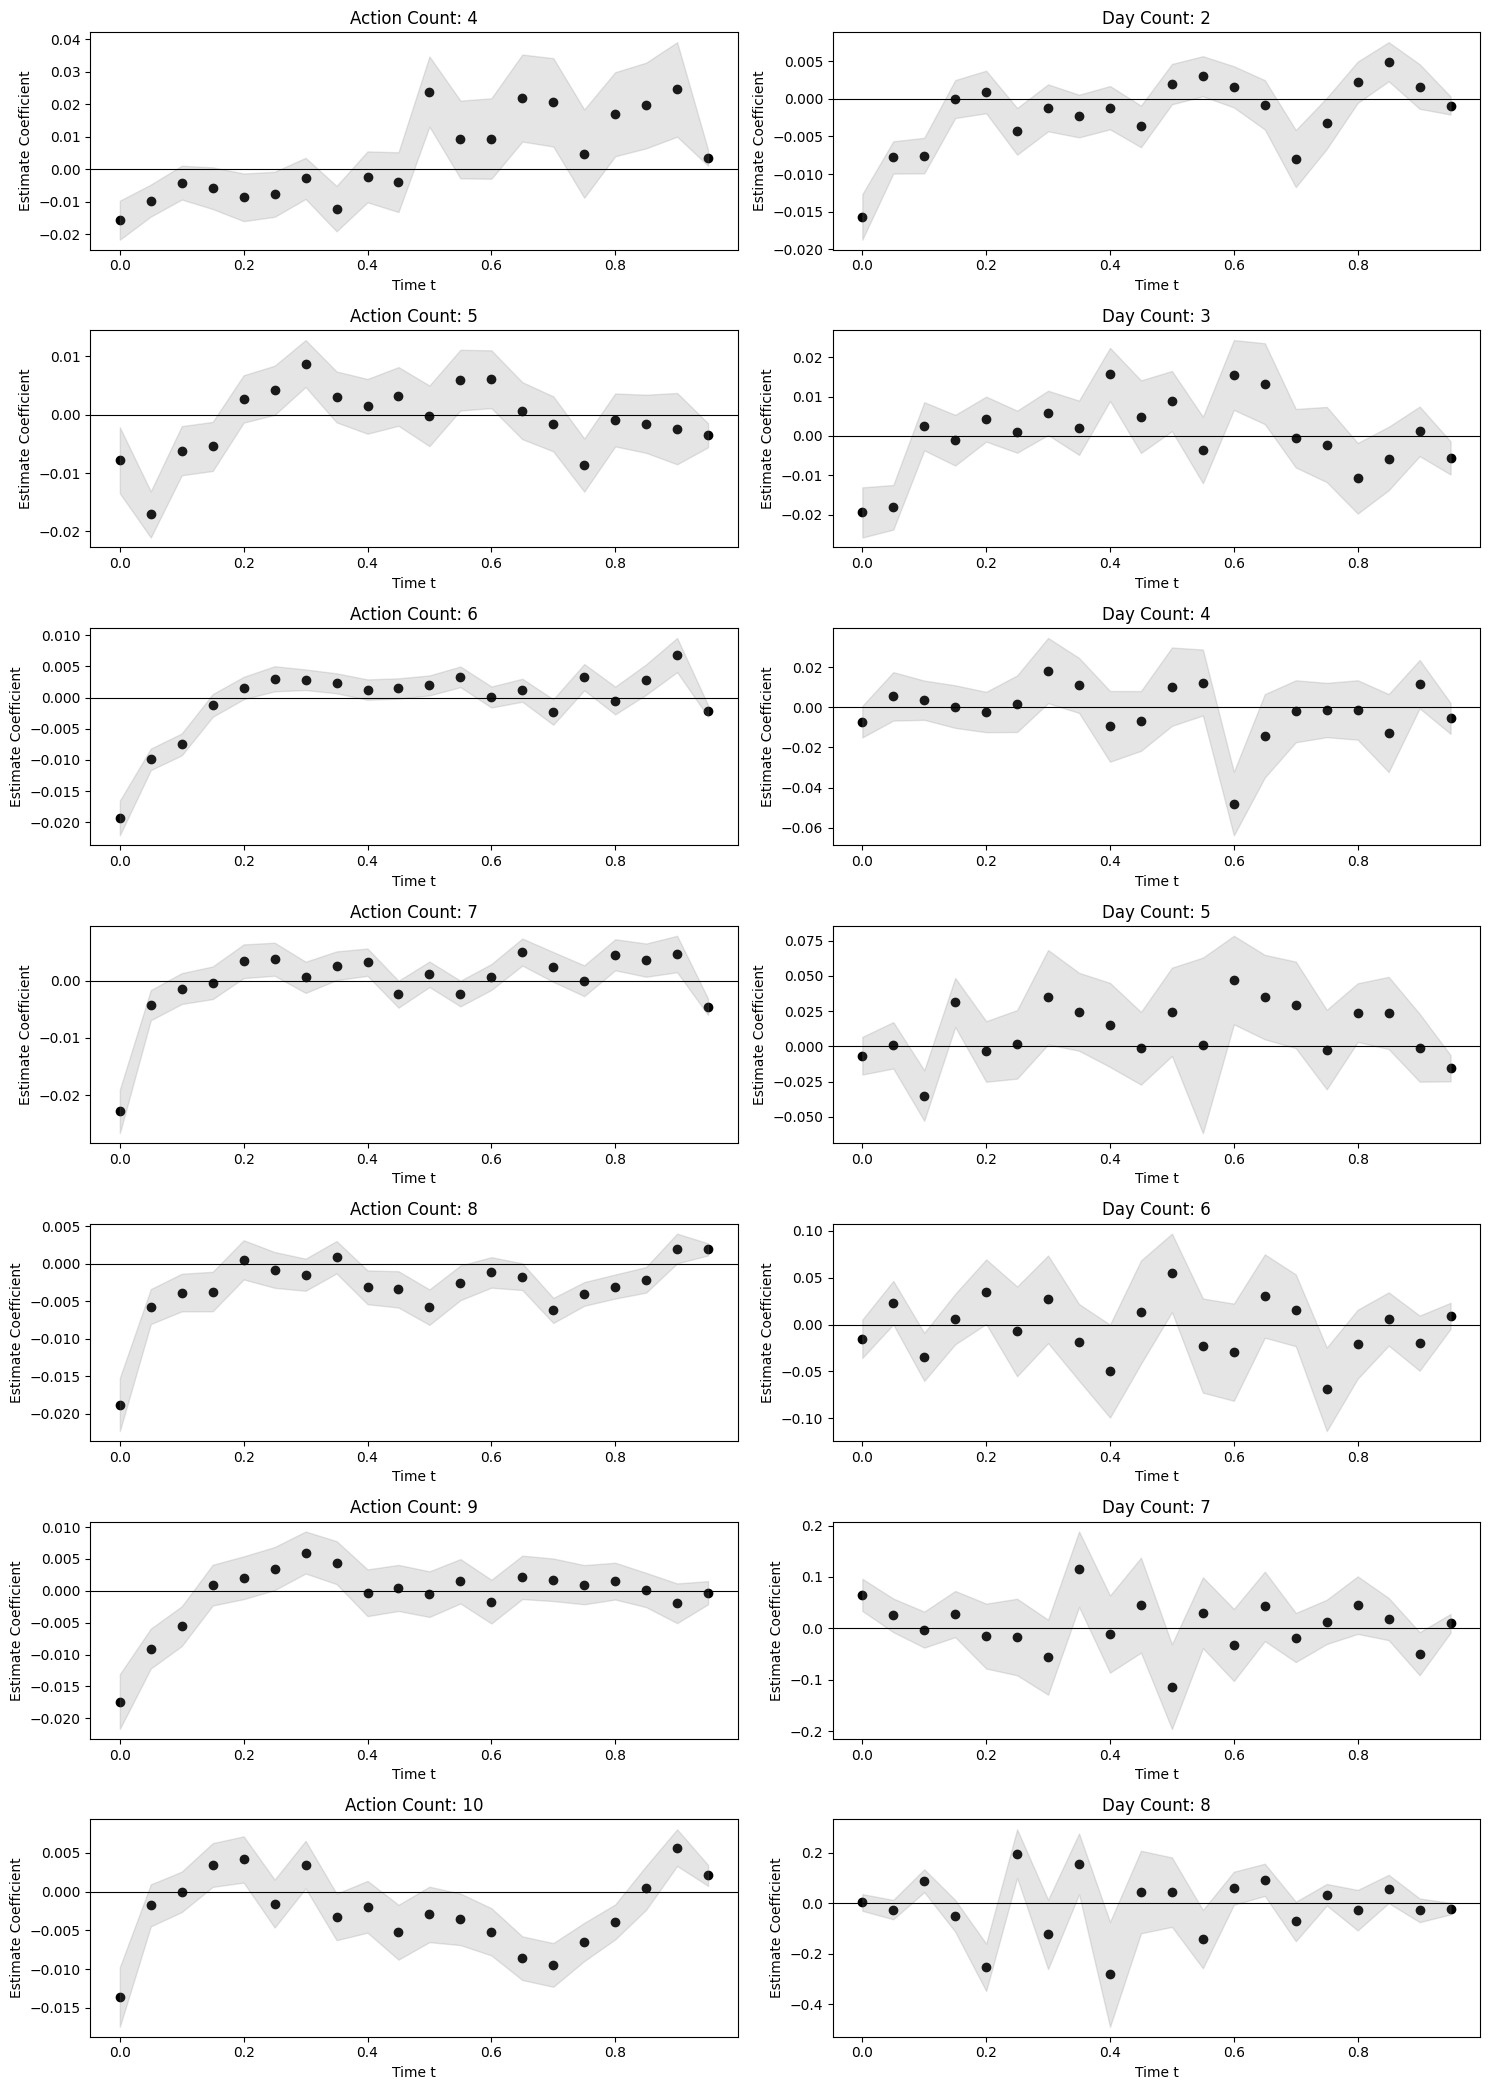

In [9]:
# Plot
plt.figure(figsize=(12, 8))

# Define the number of rows/cols for the subplot grid
cols = 2
rows = 7

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
# axs = axs.flatten()  # Flatten the axis array for easy iteration if it's 2D

for idx, action_count in enumerate(range(4, 11)):
    # Sample data
    x = np.array(BINS)
    y = np.array(action_count_coefficients[idx])
    upper_conf_int = np.array(action_count_upper_conf_ints[idx])
    lower_conf_int = np.array(action_count_lower_conf_ints[idx])

    # Scatter plot
    axs[idx][0].scatter(x, y, color='black')

    # Confidence intervals
    axs[idx][0].fill_between(x, lower_conf_int, upper_conf_int, interpolate=True, color='gray', alpha=0.2)

    # Optional: Titles and labels
    axs[idx][0].set_title(f'Action Count: {action_count}')
    axs[idx][0].set_xlabel('Time t')
    axs[idx][0].set_ylabel('Estimate Coefficient')
    axs[idx][0].axhline(0, color='black', linewidth=0.8)  # Horizontal line at y=0

for idx, day_count in enumerate(range(2, 9)):
    # Sample data
    x = np.array(BINS)
    y = np.array(day_coefficients[idx])
    upper_conf_int = np.array(day_upper_conf_ints[idx])
    lower_conf_int = np.array(day_lower_conf_ints[idx])

    # Scatter plot
    axs[idx][1].scatter(x, y, color='black')

    # Confidence intervals
    axs[idx][1].fill_between(x, lower_conf_int, upper_conf_int, interpolate=True, color='gray', alpha=0.2)

    # Optional: Titles and labels
    axs[idx][1].set_title(f'Day Count: {day_count}')
    axs[idx][1].set_xlabel('Time t')
    axs[idx][1].set_ylabel('Estimate Coefficient')
    axs[idx][1].axhline(0, color='black', linewidth=0.8)  # Horizontal line at y=0

# Adjust layout
plt.tight_layout()
plt.show()